In [1]:
import warnings;warnings.filterwarnings('ignore')

import os
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')

from datetime import datetime
from sklearn.preprocessing import MinMaxScaler

# 1.데이터 로드

In [2]:
data_path = '../data'
train_path = f'{data_path}/new/new_train_ver3.csv'
test_path  = f'{data_path}/new/new_test_ver3.csv'

print(os.listdir(data_path))

['new', 'subway_feature.csv', 'train.csv', 'test.csv', 'bus_feature.csv', 'sample_submission.csv']


In [3]:
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)
print('Train data shape : ', train_data.shape, 'Test data shape : ', test_data.shape)

Train data shape :  (1118822, 42) Test data shape :  (9272, 41)


In [4]:
# train/test 구분을 위한 칼럼 생성.
train_data['is_test'] = 0
test_data['is_test'] = 1
data = pd.concat([train_data, test_data]) # 하나의 데이터로 합친다.

print(data.shape)

(1128094, 43)


In [5]:
data.columns

Index(['본번', '부번', '아파트명', '전용면적', '층', '건축년도', '도로명', '해제사유발생일', '등기신청일자',
       '거래유형', '부동산유형', '분양형태', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-전체동수',
       'k-전체세대수', 'k-건설사', 'k-시행사', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적',
       'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)',
       'k-85㎡~135㎡이하', 'k-135㎡초과', 'k-등록일자', 'k-수정일자', '경비비관리형태', '세대전기계약방법',
       '청소비관리형태', '건축면적', '주차대수', '단지승인일', '좌표X', '좌표Y', '단지신청일', 'target',
       '구', '동', '계약날짜', 'is_test'],
      dtype='object')

In [6]:
columns_to_drop = ['아파트명', '해제사유발생일', '등기신청일자', 'k-관리방식', 'k-사용검사일-사용승인일', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과',
                   'k-등록일자', 'k-수정일자', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적']

data['본번'] = data['본번'].astype(int)
data['부번'] = data['부번'].astype(int)

df = data.drop(columns=columns_to_drop)

In [7]:
sample_data = df.sample(n=10000)
sample_data.to_csv("./sample_data.csv")

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1128094 entries, 0 to 9271
Data columns (total 28 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   본번         1128094 non-null  int64  
 1   부번         1128094 non-null  int64  
 2   전용면적       1128094 non-null  float64
 3   층          1128094 non-null  int64  
 4   건축년도       1128094 non-null  int64  
 5   도로명        1128094 non-null  object 
 6   거래유형       1128094 non-null  object 
 7   부동산유형      1128094 non-null  object 
 8   분양형태       1128094 non-null  object 
 9   k-복도유형     1128094 non-null  object 
 10  k-난방방식     1128094 non-null  object 
 11  k-전체동수     250887 non-null   float64
 12  k-전체세대수    251969 non-null   float64
 13  k-건설사      1128094 non-null  object 
 14  k-시행사      1128094 non-null  object 
 15  k-연면적      251969 non-null   float64
 16  k-주거전용면적   251924 non-null   float64
 17  k-관리비부과면적  251969 non-null   float64
 18  주차대수       251817 non-null   float64
 19  단지승인일   

# 2.컬럼별 처리

## 2-1.본번

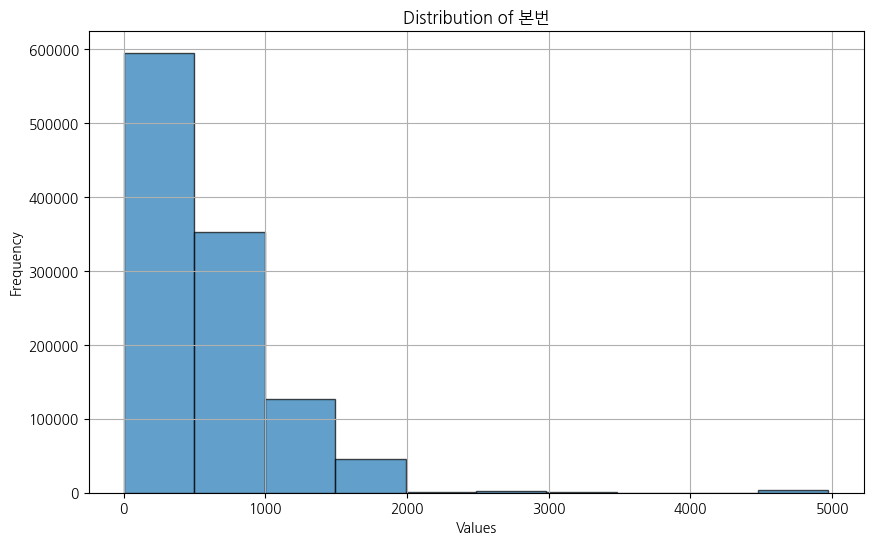

In [9]:
plt.figure(figsize=(10, 6))
plt.hist(df['본번'], bins=10, edgecolor='k', alpha=0.7)
plt.title('Distribution of 본번')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

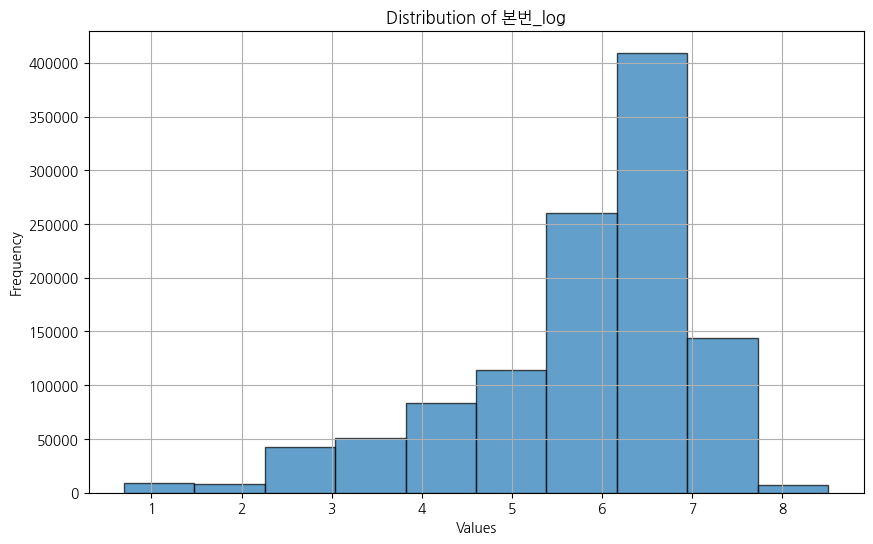

In [10]:
df['본번_log'] = np.log1p(df['본번'])

plt.figure(figsize=(10, 6))
plt.hist(df['본번_log'], bins=10, edgecolor='k', alpha=0.7)
plt.title('Distribution of 본번_log')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

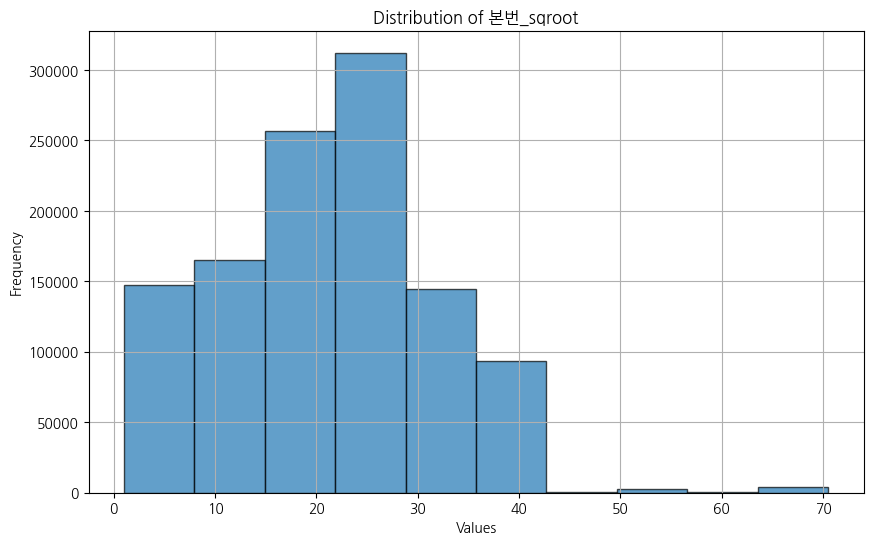

In [11]:
df['본번_sqroot'] = np.sqrt(df['본번'])

plt.figure(figsize=(10, 6))
plt.hist(df['본번_sqroot'], bins=10, edgecolor='k', alpha=0.7)
plt.title('Distribution of 본번_sqroot')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

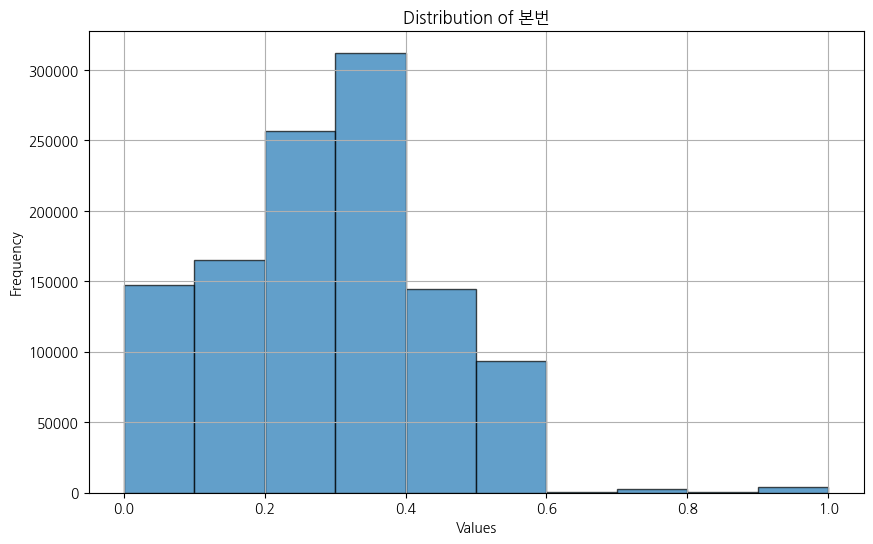

In [12]:
scaler = MinMaxScaler()
df['본번'] = scaler.fit_transform(df[['본번_sqroot']])

plt.figure(figsize=(10, 6))
plt.hist(df['본번'], bins=10, edgecolor='k', alpha=0.7)
plt.title('Distribution of 본번')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [13]:
df = df.drop(columns=['본번_log', '본번_sqroot'])
print(df.columns)

Index(['본번', '부번', '전용면적', '층', '건축년도', '도로명', '거래유형', '부동산유형', '분양형태',
       'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사', 'k-시행사', 'k-연면적',
       'k-주거전용면적', 'k-관리비부과면적', '주차대수', '단지승인일', '좌표X', '좌표Y', '단지신청일',
       'target', '구', '동', '계약날짜', 'is_test'],
      dtype='object')


## 2-2.부번

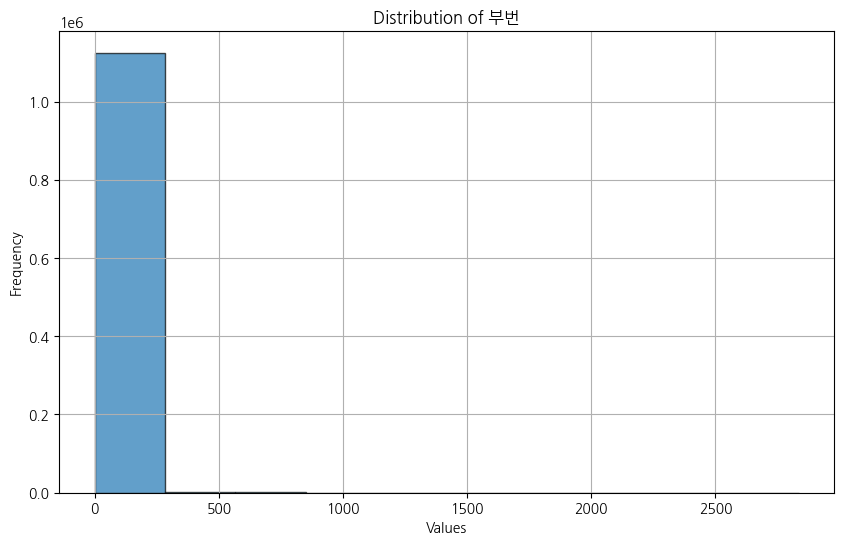

In [14]:
plt.figure(figsize=(10, 6))
plt.hist(df['부번'], bins=10, edgecolor='k', alpha=0.7)
plt.title('Distribution of 부번')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

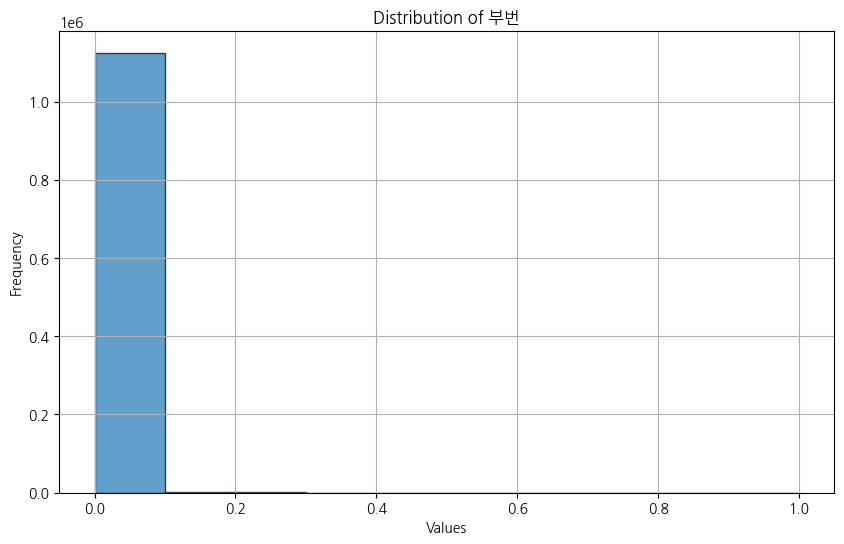

In [15]:
scaler = MinMaxScaler()
df['부번'] = scaler.fit_transform(df[['부번']])

plt.figure(figsize=(10, 6))
plt.hist(df['부번'], bins=10, edgecolor='k', alpha=0.7)
plt.title('Distribution of 부번')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## 2-3.전용면적

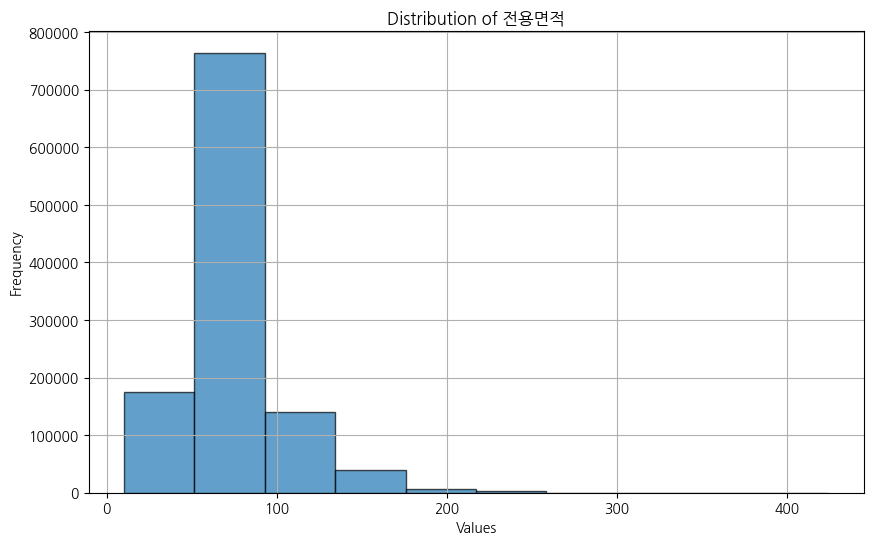

In [16]:
plt.figure(figsize=(10, 6))
plt.hist(df['전용면적'], bins=10, edgecolor='k', alpha=0.7)
plt.title('Distribution of 전용면적')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

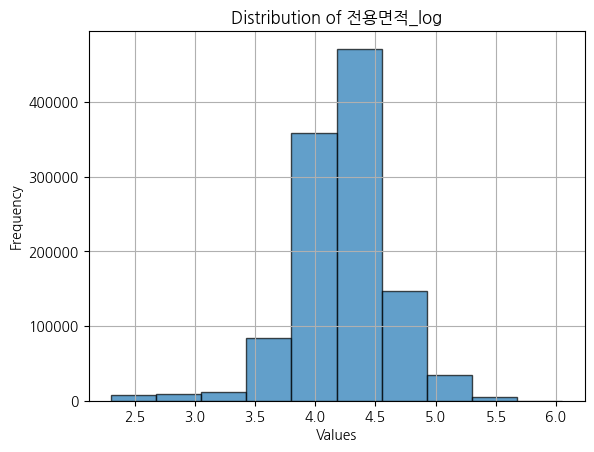

In [17]:
df['전용면적_log'] = np.log(df['전용면적'])

plt.hist(df['전용면적_log'], bins=10, edgecolor='k', alpha=0.7)
plt.title('Distribution of 전용면적_log')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [18]:
print(df.columns)

Index(['본번', '부번', '전용면적', '층', '건축년도', '도로명', '거래유형', '부동산유형', '분양형태',
       'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사', 'k-시행사', 'k-연면적',
       'k-주거전용면적', 'k-관리비부과면적', '주차대수', '단지승인일', '좌표X', '좌표Y', '단지신청일',
       'target', '구', '동', '계약날짜', 'is_test', '전용면적_log'],
      dtype='object')


In [19]:
df = df.drop(columns=['전용면적_log'])
df['전용면적'] = np.log(df['전용면적'])
print(df.columns)

Index(['본번', '부번', '전용면적', '층', '건축년도', '도로명', '거래유형', '부동산유형', '분양형태',
       'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사', 'k-시행사', 'k-연면적',
       'k-주거전용면적', 'k-관리비부과면적', '주차대수', '단지승인일', '좌표X', '좌표Y', '단지신청일',
       'target', '구', '동', '계약날짜', 'is_test'],
      dtype='object')


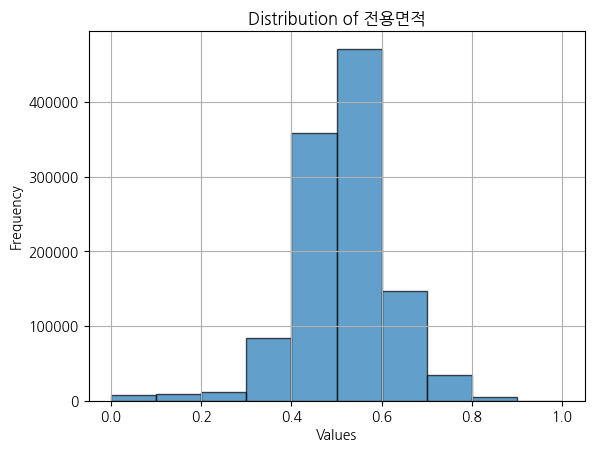

In [20]:
scaler = MinMaxScaler()
df['전용면적'] = scaler.fit_transform(df[['전용면적']])

plt.hist(df['전용면적'], bins=10, edgecolor='k', alpha=0.7)
plt.title('Distribution of 전용면적')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## 2-3.계약날짜

부동산 거래를 한 시점이므로 금리나 GDP와 같은 데이터와 연계하는데 사용가능할듯. 대신 추가 정보가 데이터프레임에 추가되고 나서는 삭제하거나 시계열로 다루는 기준이 될 뿐 학습에 직접적으로 반영되지는 않을듯

In [21]:
df['계약날짜'].info

<bound method Series.info of 0       2017-12-08
1       2017-12-22
2       2017-12-28
3       2018-01-03
4       2018-01-08
           ...    
9267    2023-07-19
9268    2023-07-25
9269    2023-08-27
9270    2023-09-02
9271    2023-09-04
Name: 계약날짜, Length: 1128094, dtype: object>

In [22]:
df['계약날짜'] = pd.to_datetime(df['계약날짜'], format='%Y-%m-%d')

In [23]:
df['계약날짜'].info

<bound method Series.info of 0      2017-12-08
1      2017-12-22
2      2017-12-28
3      2018-01-03
4      2018-01-08
          ...    
9267   2023-07-19
9268   2023-07-25
9269   2023-08-27
9270   2023-09-02
9271   2023-09-04
Name: 계약날짜, Length: 1128094, dtype: datetime64[ns]>

In [24]:
oldest_date = data['계약날짜'].min()
most_recent_date = data['계약날짜'].max()

print(oldest_date, most_recent_date)

2007-01-01 2023-09-26


In [25]:
base_date = base_date = pd.Timestamp('2006-12-31')
df['계약날짜_경과일'] = (df['계약날짜'] - base_date).dt.days
# df.drop(columns=['계약날짜'], inplace=True)

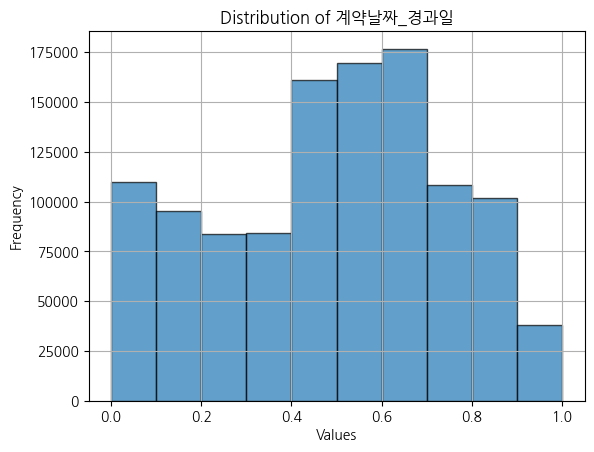

In [26]:
scaler = MinMaxScaler()
df['계약날짜_경과일'] = scaler.fit_transform(df[['계약날짜_경과일']])

plt.hist(df['계약날짜_경과일'], bins=10, edgecolor='k', alpha=0.7)
plt.title('Distribution of 계약날짜_경과일')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## 2-4.층

In [27]:
print(df['층'].min(), df['층'].max())
print(df['층'].value_counts())

-4 69
층
 5     82748
 4     82633
 3     81089
 2     77575
 6     74215
       ...  
 65        6
 67        6
 68        6
-4         4
 69        2
Name: count, Length: 73, dtype: int64


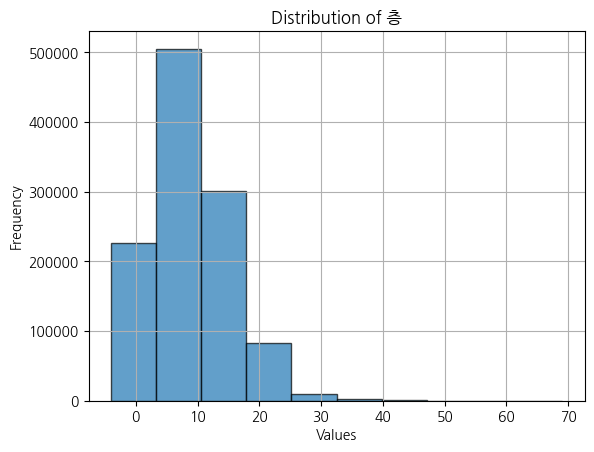

In [28]:
plt.hist(df['층'], edgecolor='k', alpha=0.7)
plt.title('Distribution of 층')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

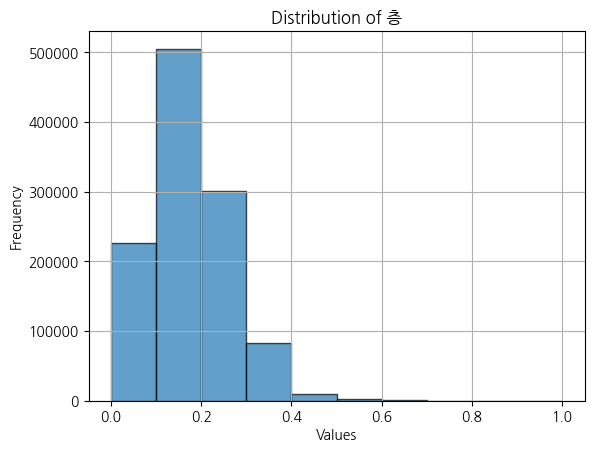

In [29]:
scaler = MinMaxScaler()
df['층'] = scaler.fit_transform(df[['층']])

plt.hist(df['층'], bins=10, edgecolor='k', alpha=0.7)
plt.title('Distribution of 층')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 3.GDP 추가

In [30]:
kor_gdp = pd.read_csv(f"{data_path}/new/kor-gdp.csv")
kor_gdp.head()

,통계표,계정항목,단위,변환,2001,2002,2003,2004,2005,2006,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,9.1.4.2. 국제 주요국 국내총생산(GDP),한국,백만달러,원자료,"547,743.1","626,989.2","702,696.2","792,532.0","934,707.9","1,052,610.2",...,"1,484,488.5","1,466,038.9","1,499,679.8","1,623,074.1","1,725,373.4","1,651,422.9","1,644,312.8","1,818,432.2","1,673,916.5","1,712,792.9"


In [31]:
gdp_data_cleaned = kor_gdp.melt(id_vars=["통계표", "계정항목", "단위", "변환"], 
                                 var_name="Year", 
                                 value_name="GDP")
gdp_data_cleaned = gdp_data_cleaned[gdp_data_cleaned["계정항목"] == "한국"]
gdp_data_cleaned = gdp_data_cleaned[["Year", "GDP"]]
gdp_data_cleaned["Year"] = gdp_data_cleaned["Year"].astype(int)
gdp_data_cleaned["GDP"] = gdp_data_cleaned["GDP"].str.replace(',', '').astype(float)

df['계약날짜'] = pd.to_datetime(df['계약날짜'])
df['Year'] = df['계약날짜'].dt.year

df = pd.merge(df, gdp_data_cleaned, on='Year', how='left')
df = df.drop(columns=['Year'])

In [32]:
df.head()

,본번,부번,전용면적,층,건축년도,도로명,거래유형,부동산유형,분양형태,k-복도유형,...,좌표X,좌표Y,단지신청일,target,구,동,계약날짜,is_test,계약날짜_경과일,GDP
0,0.354562,0.000352,0.554490,0.095890,1987,언주로 3,-,아파트,분양,계단식,...,127.05721,37.476763,2022-11-17 10:19:06.0,124000.0,강남구,개포동,2017-12-08,0,0.653469,1623074.1
1,0.354562,0.000352,0.554490,0.109589,1987,언주로 3,-,아파트,분양,계단식,...,127.05721,37.476763,2022-11-17 10:19:06.0,123500.0,강남구,개포동,2017-12-22,0,0.655759,1623074.1
2,0.354562,0.000352,0.454466,0.123288,1987,언주로 3,-,아파트,분양,계단식,...,127.05721,37.476763,2022-11-17 10:19:06.0,91500.0,강남구,개포동,2017-12-28,0,0.656741,1623074.1
3,0.354562,0.000352,0.554490,0.109589,1987,언주로 3,-,아파트,분양,계단식,...,127.05721,37.476763,2022-11-17 10:19:06.0,130000.0,강남구,개포동,2018-01-03,0,0.657723,1725373.4
4,0.354562,0.000352,0.554490,0.082192,1987,언주로 3,-,아파트,분양,계단식,...,127.05721,37.476763,2022-11-17 10:19:06.0,117000.0,강남구,개포동,2018-01-08,0,0.658541,1725373.4


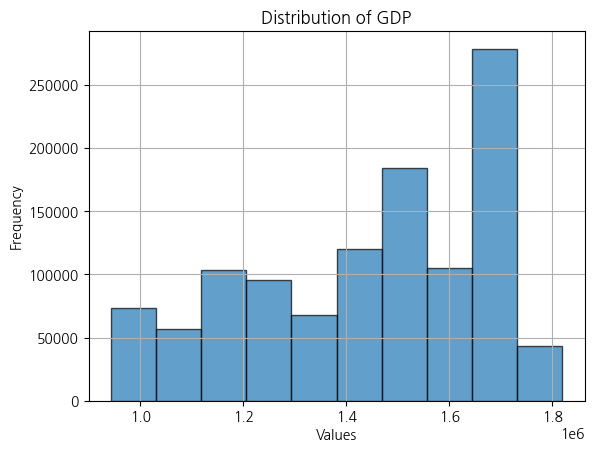

In [33]:
plt.hist(df['GDP'], edgecolor='k', alpha=0.7)
plt.title('Distribution of GDP')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

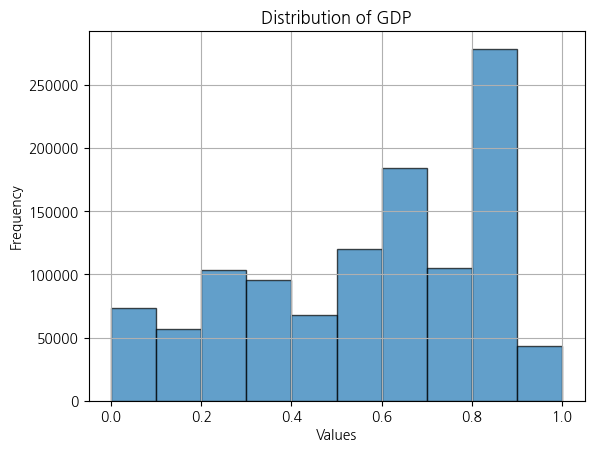

In [34]:
scaler = MinMaxScaler()
df['GDP'] = scaler.fit_transform(df[['GDP']])

plt.hist(df['GDP'], bins=10, edgecolor='k', alpha=0.7)
plt.title('Distribution of GDP')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 4. 기준금리 추가

In [35]:
kor_ir = pd.read_csv(f"{data_path}/new/kor-ir.csv")
kor_ir.head()

,Interest Rate Type,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,기준금리,5.0,3.0,2.0,2.5,3.25,2.75,2.5,2.0,1.5,1.25,1.5,1.75,1.25,0.5,1.0,3.25,3.5


In [36]:
df['계약연도'] = pd.to_datetime(df['계약날짜']).dt.year
df['계약연도'] = df['계약연도'].astype(int)

interest_rate_data_transposed = kor_ir.set_index('Interest Rate Type').T
interest_rate_data_transposed.index = interest_rate_data_transposed.index.astype(int)

df['IR'] = df['계약연도'].map(interest_rate_data_transposed['기준금리'])
df = df.drop(columns=['계약연도'])

In [37]:
df.head()

,본번,부번,전용면적,층,건축년도,도로명,거래유형,부동산유형,분양형태,k-복도유형,...,좌표Y,단지신청일,target,구,동,계약날짜,is_test,계약날짜_경과일,GDP,IR
0,0.354562,0.000352,0.554490,0.095890,1987,언주로 3,-,아파트,분양,계단식,...,37.476763,2022-11-17 10:19:06.0,124000.0,강남구,개포동,2017-12-08,0,0.653469,0.776663,1.50
1,0.354562,0.000352,0.554490,0.109589,1987,언주로 3,-,아파트,분양,계단식,...,37.476763,2022-11-17 10:19:06.0,123500.0,강남구,개포동,2017-12-22,0,0.655759,0.776663,1.50
2,0.354562,0.000352,0.454466,0.123288,1987,언주로 3,-,아파트,분양,계단식,...,37.476763,2022-11-17 10:19:06.0,91500.0,강남구,개포동,2017-12-28,0,0.656741,0.776663,1.50
3,0.354562,0.000352,0.554490,0.109589,1987,언주로 3,-,아파트,분양,계단식,...,37.476763,2022-11-17 10:19:06.0,130000.0,강남구,개포동,2018-01-03,0,0.657723,0.893613,1.75
4,0.354562,0.000352,0.554490,0.082192,1987,언주로 3,-,아파트,분양,계단식,...,37.476763,2022-11-17 10:19:06.0,117000.0,강남구,개포동,2018-01-08,0,0.658541,0.893613,1.75


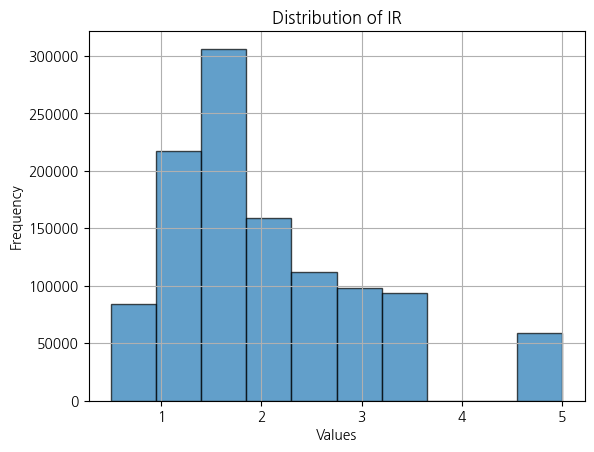

In [38]:
plt.hist(df['IR'], edgecolor='k', alpha=0.7)
plt.title('Distribution of IR')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

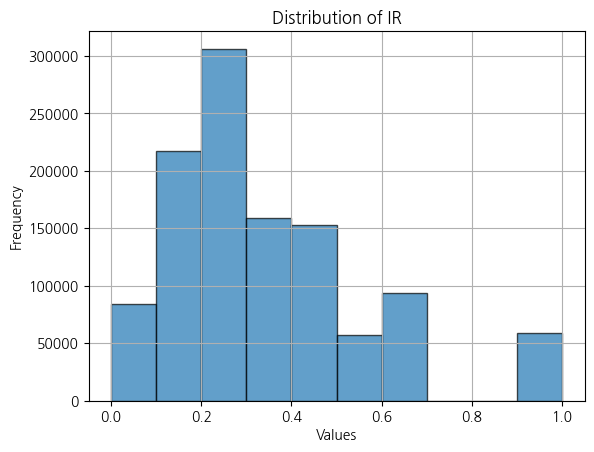

In [39]:
scaler = MinMaxScaler()
df['IR'] = scaler.fit_transform(df[['IR']])

plt.hist(df['IR'], bins=10, edgecolor='k', alpha=0.7)
plt.title('Distribution of IR')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()